In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set()


""" 
DSC672
Team: John Matune, Mike Yacobucci, Steve Rummel
Project: Energy Consumption and Renewable Energy
Purpose: 

Import power consumption data from the relevant source files, 
convert string-format date and time into valid datetime values,
remove unneeded columns, normalize column headers, and
export to canonical data source for further analysis.
"""

consumption_files = ['powercity_consumption.csv',
                     'calendar_days_consumption.csv',
                     'car_charging.csv'
                     ]

for file in consumption_files:
    consumption = pd.read_csv('./raw/{}'.format(file))
    print(file)
    print(consumption.head())
    print(consumption.dtypes)
    for field in list(consumption):
        print("--------------------")
        print(field)
        print(consumption[field].describe())
        print("--------------------")
    print("********************")



powercity_consumption.csv
          Year  Month  Day  Hour        Sector  Electricity_KW_SQFT
0  Consumption      1    1     1  FOOD_SERVICE             0.005416
1  Consumption      1    1     1       GROCERY             0.002030
2  Consumption      1    1     1   HEALTH_CARE             0.002390
3  Consumption      1    1     1   K12_SCHOOLS             0.000818
4  Consumption      1    1     1       LODGING             0.001209
Year                    object
Month                    int64
Day                      int64
Hour                     int64
Sector                  object
Electricity_KW_SQFT    float64
dtype: object
--------------------
Year
count           70080
unique              1
top       Consumption
freq            70080
Name: Year, dtype: object
--------------------
--------------------
Month
count    70080.000000
mean         6.526027
std          3.447876
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Na

In [2]:
# Process calendar_days_consumption.csv

calendar = pd.read_csv('./raw/calendar_days_consumption.csv')

for field in list(calendar):
    #calendar[field].fillna('FALSE', inplace=True)
    calendar[field] = calendar[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
calendar['Month'] = calendar['Month'].apply('{:0>2}'.format)
calendar['Day'] = calendar['Day'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
calendar['MD'] = calendar[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)
calendar['MD'] = pd.to_datetime(calendar['MD'], format='%m:%d')

drop_these = ['Year', 'Month', 'Day']
for field in drop_these:
    calendar.drop([field], axis=1, inplace=True)
    
workdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
conditions = [((calendar['Weekdays'].isin(workdays)) &
               (calendar['HolidayName'] == 'FALSE'))]
choices = [True]
calendar['Workday'] = np.select(conditions, choices, default=False)

calendar.set_index('MD', inplace=True)
print(calendar.head(15))
#print(calendar['Weekdays'].unique())

           Day_of_week Weekdays     HolidayName School_Day  Workday
MD                                                                 
1900-01-01           1      Sun  New Year's Day          0    False
1900-01-02           2      Mon             nan          0    False
1900-01-03           3      Tue             nan          0    False
1900-01-04           4      Wed             nan          0    False
1900-01-05           5      Thu             nan          0    False
1900-01-06           6      Fri             nan          0    False
1900-01-07           7      Sat             nan          0    False
1900-01-08           1      Sun             nan          0    False
1900-01-09           2      Mon             nan          1    False
1900-01-10           3      Tue             nan          1    False
1900-01-11           4      Wed             nan          1    False
1900-01-12           5      Thu             nan          1    False
1900-01-13           6      Fri             nan 

In [3]:
# Process powercity_consumption.csv
pwrcty_cons = pd.read_csv('./raw/powercity_consumption.csv')
pwrcty_cons['Hour'] = pwrcty_cons['Hour'].astype(int) - 1

for field in list(pwrcty_cons):
    #pwrcty_cons[field].fillna(0.0, inplace=True)
    pwrcty_cons[field] = pwrcty_cons[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.

pwrcty_cons['Month'] = pwrcty_cons['Month'].apply('{:0>2}'.format)
pwrcty_cons['Day'] = pwrcty_cons['Day'].apply('{:0>2}'.format)
pwrcty_cons['Hour'] = pwrcty_cons['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
pwrcty_cons['Time'] = pwrcty_cons[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

pwrcty_cons['Time'] = pd.to_datetime(pwrcty_cons['Time'], format='%m:%d')
pwrcty_cons['Time'] +=  pd.to_timedelta(pwrcty_cons['Hour'].astype(int), unit='h')
#pwrcty_cons.set_index('Time', inplace=True)

drop_these = ['Year', 'Month', 'Day', 'Hour']
for field in drop_these:
    pwrcty_cons.drop([field], axis=1, inplace=True)
    
pwc_pivot = pwrcty_cons.pivot(index='Time', columns='Sector', values='Electricity_KW_SQFT')

# Create a string version of  timestamp.
pwc_pivot.reset_index(inplace=True)
pwc_pivot['MD'] = pd.DatetimeIndex(pwc_pivot['Time']).normalize()
pwc_pivot.set_index('MD', inplace=True)

print(pwc_pivot.head())


Sector                    Time           FOOD_SERVICE                GROCERY  \
MD                                                                             
1900-01-01 1900-01-01 00:00:00           0.0054160664           0.0020302509   
1900-01-01 1900-01-01 01:00:00           0.0037892151  0.0020316304999999997   
1900-01-01 1900-01-01 02:00:00  0.0037971470000000003  0.0019766379999999997   
1900-01-01 1900-01-01 03:00:00  0.0038017171999999997           0.0020681732   
1900-01-01 1900-01-01 04:00:00           0.0038614936           0.0021763971   

Sector       HEALTH_CARE            K12_SCHOOLS       LODGING  \
MD                                                              
1900-01-01   0.002389971           0.0008177919  0.0012087326   
1900-01-01  0.0024429674           0.0008148465  0.0012147583   
1900-01-01  0.0024131239           0.0008237725  0.0011489547   
1900-01-01  0.0024056954  0.0008170464999999999  0.0011635804   
1900-01-01  0.0024284718  0.0008250546000000001  

In [4]:
# Join our car charging to other consumption sources:
consumption_master = pwc_pivot
consumption_master = consumption_master.join(calendar, how='outer', sort=True)

consumption_master.reset_index(inplace=True)
consumption_master.set_index('Time', inplace=True)

print(consumption_master.head())

                            MD           FOOD_SERVICE                GROCERY  \
Time                                                                           
1900-01-01 00:00:00 1900-01-01           0.0054160664           0.0020302509   
1900-01-01 01:00:00 1900-01-01           0.0037892151  0.0020316304999999997   
1900-01-01 02:00:00 1900-01-01  0.0037971470000000003  0.0019766379999999997   
1900-01-01 03:00:00 1900-01-01  0.0038017171999999997           0.0020681732   
1900-01-01 04:00:00 1900-01-01           0.0038614936           0.0021763971   

                      HEALTH_CARE            K12_SCHOOLS       LODGING  \
Time                                                                     
1900-01-01 00:00:00   0.002389971           0.0008177919  0.0012087326   
1900-01-01 01:00:00  0.0024429674           0.0008148465  0.0012147583   
1900-01-01 02:00:00  0.0024131239           0.0008237725  0.0011489547   
1900-01-01 03:00:00  0.0024056954  0.0008170464999999999  0.001163580

In [5]:
# Process car_charging.csv
car_chrg = pd.read_csv('./raw/car_charging.csv')
car_chrg['Hour'] = car_chrg['Hour'].astype(int) - 1

for field in list(car_chrg):
    #car_chrg[field].fillna(0.0, inplace=True)
    car_chrg[field] = car_chrg[field].astype(str)
    
# Pad out the Month, Day and Hour values because .to_datetime wont processed unpadded integers.
car_chrg['Month'] = car_chrg['Month'].apply('{:0>2}'.format)
car_chrg['Day'] = car_chrg['Day'].apply('{:0>2}'.format)
car_chrg['Hour'] = car_chrg['Hour'].apply('{:0>2}'.format)

# Create a string version of  timestamp.
car_chrg['Time'] = car_chrg[['Month', 'Day']].apply(lambda x: ':'.join(x), axis=1)

car_chrg['Time'] = pd.to_datetime(car_chrg['Time'], format='%m:%d')
car_chrg['Time'] +=  pd.to_timedelta(car_chrg['Hour'].astype(int), unit='h')

drop_these = ['Year', 'Month', 'Day', 'Hour']
for field in drop_these:
    car_chrg.drop([field], axis=1, inplace=True)
    
car_pivot = car_chrg.pivot(index='Time', columns='Consumption_type', values='Electricity_KW_SQFT')
print(car_pivot.head())

Consumption_type     ELECTRIC_CAR
Time                             
1900-01-01 00:00:00  22597.669011
1900-01-01 01:00:00  22597.669011
1900-01-01 02:00:00  22597.669011
1900-01-01 03:00:00  22597.669011
1900-01-01 04:00:00  22597.669011


In [6]:
# Join our car charging to other consumption sources:
consumption_master = consumption_master.join(car_pivot, how='outer', sort=True)



In [7]:
drop_these = ['MD', 'Day_of_week']
for field in drop_these:
    consumption_master.drop([field], axis=1, inplace=True)

print(consumption_master.head())

                              FOOD_SERVICE                GROCERY  \
Time                                                                
1900-01-01 00:00:00           0.0054160664           0.0020302509   
1900-01-01 01:00:00           0.0037892151  0.0020316304999999997   
1900-01-01 02:00:00  0.0037971470000000003  0.0019766379999999997   
1900-01-01 03:00:00  0.0038017171999999997           0.0020681732   
1900-01-01 04:00:00           0.0038614936           0.0021763971   

                      HEALTH_CARE            K12_SCHOOLS       LODGING  \
Time                                                                     
1900-01-01 00:00:00   0.002389971           0.0008177919  0.0012087326   
1900-01-01 01:00:00  0.0024429674           0.0008148465  0.0012147583   
1900-01-01 02:00:00  0.0024131239           0.0008237725  0.0011489547   
1900-01-01 03:00:00  0.0024056954  0.0008170464999999999  0.0011635804   
1900-01-01 04:00:00  0.0024284718  0.0008250546000000001  0.0012112123  

In [8]:
#consumption_master.to_pickle("./processed/consumption_master.pkl")

In [9]:
population = pd.read_csv('./raw/powercity_population.csv')
brackets = ['<5','5>18','18>25','25>65','65+']
fsvce = ['0.0', '2.7326926172677', '15.485258164517', '10.9307704690708', '10.0198729299816']
hcare=['20.1787369600578', '2.06390856763344', '5.9572198066756', '10.5890957469236', '9.02894015480447']
k12=['0', '140', '0', '0', '0']
Lodg=['0', '1.59547552713553', '6.38190210854211', '12.7638042170842', '9.57285316281317']
Ofc=['0', '0', '107.411616351485', '150.376262892079', '10.7411616351485']
Resid=['58.1636704', '151.2255432', '581.6367045', '1163.2734090', '814.2913863']
Groc=['0', '1.2182672404555', '4.26393534159424', '7.30960344273298', '4.87306896182199']
SAR=['0', '1.70063712655312', '12.7547784491484', '11.9044598858719', '10.2038227593187']
sectors = [['FOOD_SERVICE', fsvce],
           ['HEALTHCARE', hcare],
           ['K12', k12],
           ['LODGING', Lodg],
           ['OFFICE', Ofc],
           ['RESIDENTIAL', Resid],
           ['GROCERY', Groc],
           ['STAND_ALONE_RETAIL', SAR]]

numeric_fields = ['Total','<5', '5>18', '18>25', '25>65', '65+']
for field in numeric_fields:
    #population[field].fillna('0.0', inplace=True)
    population[field] = population[field].apply(pd.to_numeric, errors='coerce')
                  
for sector in sectors:
    for index, bracket in enumerate(brackets):
        population[sector[0] + '_' + bracket + '_SF'] = pd.to_numeric(sector[1][index]) * population[bracket]
        
print(population.head())
population.to_pickle("./processed/total_square_footage_by_tractID_and_population.pkl")

  Tract_ID        CITY  Total  <5  5>18  18>25  25>65  65+  \
0     A250  Power City      2   0     0      1      1    0   
1     A251  Power City     30   2     5      2     16    4   
2     A252  Power City     85   5    13     10     48    8   
3     A253  Power City    163  10    41     11     90   10   
4     A254  Power City     85   0     1     81      2    1   

   FOOD_SERVICE_<5_SF  FOOD_SERVICE_5>18_SF            ...              \
0                 0.0              0.000000            ...               
1                 0.0             13.663463            ...               
2                 0.0             35.525004            ...               
3                 0.0            112.040397            ...               
4                 0.0              2.732693            ...               

   GROCERY_<5_SF  GROCERY_5>18_SF  GROCERY_18>25_SF  GROCERY_25>65_SF  \
0              0         0.000000          4.263935          7.309603   
1              0         6.091336   

In [10]:
pop_sum = population.groupby('CITY').sum()
field_list = ['FOOD_SERVICE_<5_SF',
'FOOD_SERVICE_5>18_SF',
'FOOD_SERVICE_18>25_SF',
'FOOD_SERVICE_25>65_SF',
'FOOD_SERVICE_65+_SF',
'HEALTHCARE_<5_SF',
'HEALTHCARE_5>18_SF',
'HEALTHCARE_18>25_SF',
'HEALTHCARE_25>65_SF',
'HEALTHCARE_65+_SF',
'K12_<5_SF',
'K12_5>18_SF',
'K12_18>25_SF',
'K12_25>65_SF',
'K12_65+_SF',
'LODGING_<5_SF',
'LODGING_5>18_SF',
'LODGING_18>25_SF',
'LODGING_25>65_SF',
'LODGING_65+_SF',
'OFFICE_<5_SF',
'OFFICE_5>18_SF',
'OFFICE_18>25_SF',
'OFFICE_25>65_SF',
'OFFICE_65+_SF',
'RESIDENTIAL_<5_SF',
'RESIDENTIAL_5>18_SF',
'RESIDENTIAL_18>25_SF',
'RESIDENTIAL_25>65_SF',
'RESIDENTIAL_65+_SF',
'GROCERY_<5_SF',
'GROCERY_5>18_SF',
'GROCERY_18>25_SF',
'GROCERY_25>65_SF',
'GROCERY_65+_SF',
'STAND_ALONE_RETAIL_<5_SF',
'STAND_ALONE_RETAIL_5>18_SF',
'STAND_ALONE_RETAIL_18>25_SF',
'STAND_ALONE_RETAIL_25>65_SF',
'STAND_ALONE_RETAIL_65+_SF']

pop_sum = pop_sum[field_list]
    
food_svc = ['FOOD_SERVICE_<5_SF',
            'FOOD_SERVICE_5>18_SF',
            'FOOD_SERVICE_18>25_SF',
            'FOOD_SERVICE_25>65_SF',
            'FOOD_SERVICE_65+_SF']

healthcare = ['HEALTHCARE_<5_SF',
              'HEALTHCARE_5>18_SF',
              'HEALTHCARE_18>25_SF',
              'HEALTHCARE_25>65_SF',
              'HEALTHCARE_65+_SF']

k12 = ['K12_<5_SF',
       'K12_5>18_SF',
       'K12_18>25_SF',
       'K12_25>65_SF',
       'K12_65+_SF']

lodging = ['LODGING_<5_SF',
           'LODGING_5>18_SF',
           'LODGING_18>25_SF',
           'LODGING_25>65_SF',
           'LODGING_65+_SF']

office = ['OFFICE_<5_SF',
          'OFFICE_5>18_SF',
          'OFFICE_18>25_SF',
          'OFFICE_25>65_SF',
          'OFFICE_65+_SF']

residential = ['RESIDENTIAL_<5_SF',
               'RESIDENTIAL_5>18_SF',
               'RESIDENTIAL_18>25_SF',
               'RESIDENTIAL_25>65_SF',
               'RESIDENTIAL_65+_SF']

grocery = ['GROCERY_<5_SF',
           'GROCERY_5>18_SF',
           'GROCERY_18>25_SF',
           'GROCERY_25>65_SF',
           'GROCERY_65+_SF']

sa_rtl = ['STAND_ALONE_RETAIL_<5_SF',
          'STAND_ALONE_RETAIL_5>18_SF',
          'STAND_ALONE_RETAIL_18>25_SF',
          'STAND_ALONE_RETAIL_25>65_SF',
          'STAND_ALONE_RETAIL_65+_SF']

sum_flds = [['food_svc', food_svc], 
            ['healthcare', healthcare],
            ['k12', k12],
            ['lodging', lodging],
            ['office', office],
            ['residential', residential],
            ['grocery', grocery],
            ['sa_rtl', sa_rtl]]

for elem in sum_flds:
    pop_sum[elem[0]] = 0
    for field in elem[1]:
        pop_sum[elem[0]] += pop_sum[field]
        
summary_fields = ['food_svc', 
                  'healthcare',
                  'k12',
                  'lodging',
                  'office',
                  'residential',
                  'grocery',
                  'sa_rtl']

summary_data = pop_sum[summary_fields]
summary_data.reset_index(inplace=True)
summary_data = summary_data[summary_fields]
print(summary_data.head())

        food_svc     healthcare      k12        lodging        office  \
0  967558.098713  965374.296927  2426480  931129.090489  9.999731e+06   

    residential        grocery         sa_rtl  
0  8.482341e+07  539981.116858  971961.735665  


In [11]:
# Assign the relative SF to the master

consumption_master['FOOD_SVC_SF']=pd.to_numeric(summary_data['food_svc'].iloc[0])
consumption_master['GROCERY_SF']=pd.to_numeric(summary_data['grocery'].iloc[0])
consumption_master['HEALTH_CARE_SF']=pd.to_numeric(summary_data['healthcare'].iloc[0])
consumption_master['K12_SF']=pd.to_numeric(summary_data['k12'].iloc[0])
consumption_master['LODGING_SF']=pd.to_numeric(summary_data['lodging'].iloc[0])
consumption_master['OFFICE_SF']=pd.to_numeric(summary_data['office'].iloc[0])
consumption_master['RESIDENTIAL_SF']=pd.to_numeric(summary_data['residential'].iloc[0])
consumption_master['SA_RTL_SF']=pd.to_numeric(summary_data['sa_rtl'].iloc[0])
    

In [12]:
consumption_master[['FOOD_SVC_SF', 'FOOD_SERVICE']] = consumption_master[['FOOD_SVC_SF', 'FOOD_SERVICE']].astype(float)
consumption_master['FOOD_SVC_TOTAL']=consumption_master['FOOD_SVC_SF'] * consumption_master['FOOD_SERVICE']

consumption_master[['GROCERY_SF', 'GROCERY']] = consumption_master[['GROCERY_SF', 'GROCERY']].astype(float)
consumption_master['GROCERY_TOTAL']=consumption_master['GROCERY_SF'] * consumption_master['GROCERY']

consumption_master[['HEALTH_CARE_SF', 'HEALTH_CARE']] = consumption_master[['HEALTH_CARE_SF', 'HEALTH_CARE']].astype(float)
consumption_master['HEALTH_CARE_TOTAL']=consumption_master['HEALTH_CARE_SF'] * consumption_master['HEALTH_CARE']

consumption_master[['K12_SF', 'K12_SCHOOLS']] = consumption_master[['K12_SF', 'K12_SCHOOLS']].astype(float)
consumption_master['K12_TOTAL']=consumption_master['K12_SF'] * consumption_master['K12_SCHOOLS']

consumption_master[['LODGING_SF', 'LODGING']] = consumption_master[['LODGING_SF', 'LODGING']].astype(float)
consumption_master['LODGING_TOTAL']=consumption_master['LODGING_SF'] * consumption_master['LODGING']

consumption_master[['OFFICE_SF', 'OFFICE']] = consumption_master[['OFFICE_SF', 'OFFICE']].astype(float)
consumption_master['OFFICE_TOTAL']=consumption_master['OFFICE_SF'] * consumption_master['OFFICE']

consumption_master[['RESIDENTIAL_SF', 'RESIDENTIAL']] = consumption_master[['RESIDENTIAL_SF', 'RESIDENTIAL']].astype(float)
consumption_master['RESIDENTIAL_TOTAL']=consumption_master['RESIDENTIAL_SF'] * consumption_master['RESIDENTIAL']

consumption_master[['SA_RTL_SF', 'STAND_ALONE_RETAIL']] = consumption_master[['SA_RTL_SF', 'STAND_ALONE_RETAIL']].astype(float)
consumption_master['SA_RTL_TOTAL']=consumption_master['SA_RTL_SF'] * consumption_master['STAND_ALONE_RETAIL']

print(consumption_master.head())

                     FOOD_SERVICE   GROCERY  HEALTH_CARE  K12_SCHOOLS  \
Time                                                                    
1900-01-01 00:00:00      0.005416  0.002030     0.002390     0.000818   
1900-01-01 01:00:00      0.003789  0.002032     0.002443     0.000815   
1900-01-01 02:00:00      0.003797  0.001977     0.002413     0.000824   
1900-01-01 03:00:00      0.003802  0.002068     0.002406     0.000817   
1900-01-01 04:00:00      0.003861  0.002176     0.002428     0.000825   

                      LODGING    OFFICE  RESIDENTIAL  STAND_ALONE_RETAIL  \
Time                                                                       
1900-01-01 00:00:00  0.001209  0.001911     0.000541            0.000491   
1900-01-01 01:00:00  0.001215  0.001664     0.000523            0.000499   
1900-01-01 02:00:00  0.001149  0.002005     0.000517            0.000505   
1900-01-01 03:00:00  0.001164  0.001697     0.000514            0.000507   
1900-01-01 04:00:00  0.001211  0

In [13]:
consumption_master.to_pickle("./processed/consumption_master.pkl")

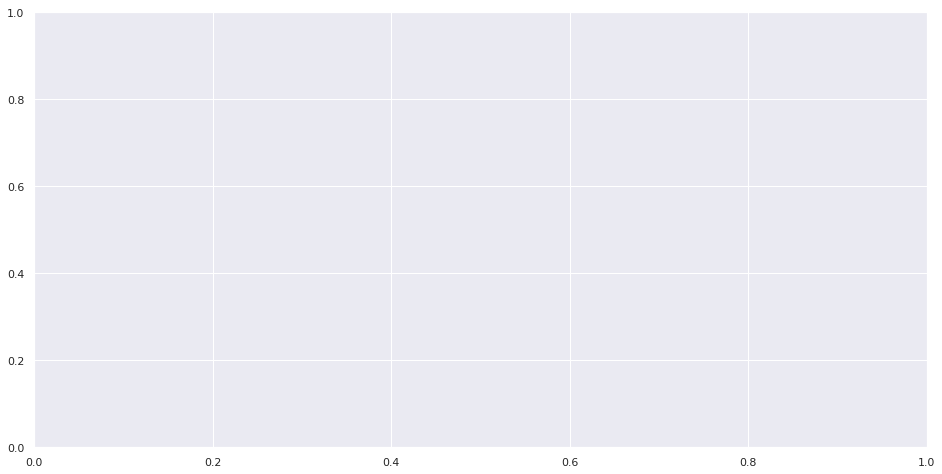

In [14]:
fields = ['FOOD_SERVICE',
          'GROCERY',
          'HEALTH_CARE',
          'K12_SCHOOLS',
          'LODGING',
          'OFFICE',
          'RESIDENTIAL',
          'STAND_ALONE_RETAIL',
          'ELECTRIC_CAR']

plot_types = ['bar', 'box']

def plot_me(field, plot_type):
    monthly_resampled = pd.to_numeric(consumption_master[field], downcast='float').resample('W').mean()
    plot = monthly_resampled.plot(kind=plot_type,subplots=False,sharex=False,sharey=False, title=field, figsize=(16, 8));
    plot.figure.savefig("./Images/{}plot_by_week_{}.png".format(plot_type, field))
    plot.cla()
    
    
for field in fields:
    plot_me(field, 'bar')